Import

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.spatial.distance import mahalanobis
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report
from torchvision.models import ResNet50_Weights
import torchvision.models as models
from PIL import Image
import torch
from torchvision import transforms
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Se CUDA disponibile, usa la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carica ResNet50 pre-addestrata e in modalità eval
weights = ResNet50_Weights.IMAGENET1K_V1  # o DEFAULT per i pesi più aggiornati
model = models.resnet50(weights=weights)
model.eval()
model.to(device)

# Preprocessing standard per ResNet
preprocess = weights.transforms()


In [3]:
# Funzione per caricare l'immagine e fare la pre-elaborazione
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor

In [4]:
# Funzione per estrarre la media su ciascuna mappa di attivazione
def extract_and_process_image(img_path, model):
    img_tensor = preprocess_image(img_path)
    features = extract_resnet_features(img_tensor, model)
    features_vector = features.detach().mean(dim=[1, 2]).cpu().numpy()
    return features_vector

In [9]:
def load_features(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    return data['features'], data['labels'], data.get('filenames', [f"img_{i}" for i in range(len(data['features']))])


feat_matrix_part1, lbls_part1, flname_part1 = load_features(
    "resnet_features_part1.npz")
feat_matrix_part2, lbls_part2, flname_part2 = load_features(
    "resnet_features_part2.npz")

In [ ]:
Task 1-2

In [6]:


# Funzione per estrarre le caratteristiche dal livello "layer3" della ResNet
def extract_resnet_features(img_tensor, model):
    def hook_fn(module, input, output):
        hook_fn.features = output

    hook = model.layer3[0].register_forward_hook(hook_fn)
    model(img_tensor)
    hook.remove()

    features = hook_fn.features.squeeze()
    return features



# Funzione per processare tutte le immagini in più sottocartelle



In [7]:
def process_and_save_features(base_folder, subfolders, output_file):
    """
    Estrae le feature FC da immagini in più cartelle e salva in un file .npz.
    """
    all_features = []
    all_filenames = []
    all_labels = []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        if not os.path.isdir(folder_path):
            print(f"[ATTENZIONE] Cartella non trovata: {folder_path}")
            continue
        print(f"[INFO] Elaboro cartella: {label}")

        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extract_and_process_image(img_path, model)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)
                else:
                    print(f"[ERRORE] Feature non estratte da {img_path}")

    # Salva in file .npz
    np.savez(output_file,
             features=np.array(all_features),
             filenames=np.array(all_filenames),
             labels=np.array(all_labels))
    
    print(f"[SALVATO] Features salvate in {output_file}")
    print(f"[FINE] Totale immagini processate: {len(all_features)}")

In [8]:
# Parametri cartelle e output
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]


# Estrazione e salvataggio
process_and_save_features("Part1", subfolders, "resnet_features_part1")
process_and_save_features("Part2", subfolders, "resnet_features_part2")

[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in resnet_features_part1
[FINE] Totale immagini processate: 3006
[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in resnet_features_part2
[FINE] Totale immagini processate: 3006


Task 3:

In [10]:

# --- Funzione con scelta metrica ---

def find_top_k_similar(query_img_path, k, features_npz_path, model, image_folder, metric):
    """
    Trova e visualizza le k immagini più simili rispetto all'immagine di query.

    Parametri:
    - query_img_path: percorso immagine di query
    - k: numero di immagini simili da mostrare
    - features_npz_path: file .npz con features, filenames, labels
    - model: modello ResNet già caricato
    - image_folder: cartella base delle immagini (per ricostruire i path)
    - metric: "euclidean" o "cosine" (default euclidean)
    """
    
    # Estrai feature per immagine query
    query_feature = extract_and_process_image(query_img_path, model).reshape(1, -1)

    if metric == "euclidean":
        # Distanza euclidea
        dists = np.linalg.norm(feat_matrix_part1 - query_feature, axis=1)
        # Più piccoli sono migliori (vicinanza)
        top_k_indices = np.argsort(dists)[:k]

    elif metric == "cosine":
        # Similarità coseno
        sim = cosine_similarity(query_feature, feat_matrix_part1)[0]  # shape: (num_features,)
        # Più alti sono migliori (similarità)
        top_k_indices = np.argsort(sim)[::-1][:k]

    else:
        raise ValueError("Metric must be 'euclidean' or 'cosine'")

    # Visualizzazione
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(top_k_indices):
        img_path = os.path.join(image_folder, lbls_part1[idx], flname_part1[idx])
        img = Image.open(img_path).convert("RGB")
        plt.subplot(1, k, i + 1)
        plt.imshow(img)
        plt.axis('off')
        if metric == "euclidean":
            plt.title(f"{flname_part1[idx]}\nDist: {dists[idx]:.4f}")
        else:
            plt.title(f"{flname_part1[idx]}\nSim: {sim[idx]:.4f}")

    plt.suptitle(f"Top-{k} immagini più simili ({metric})")
    plt.tight_layout()
    plt.show()





Esecuzione

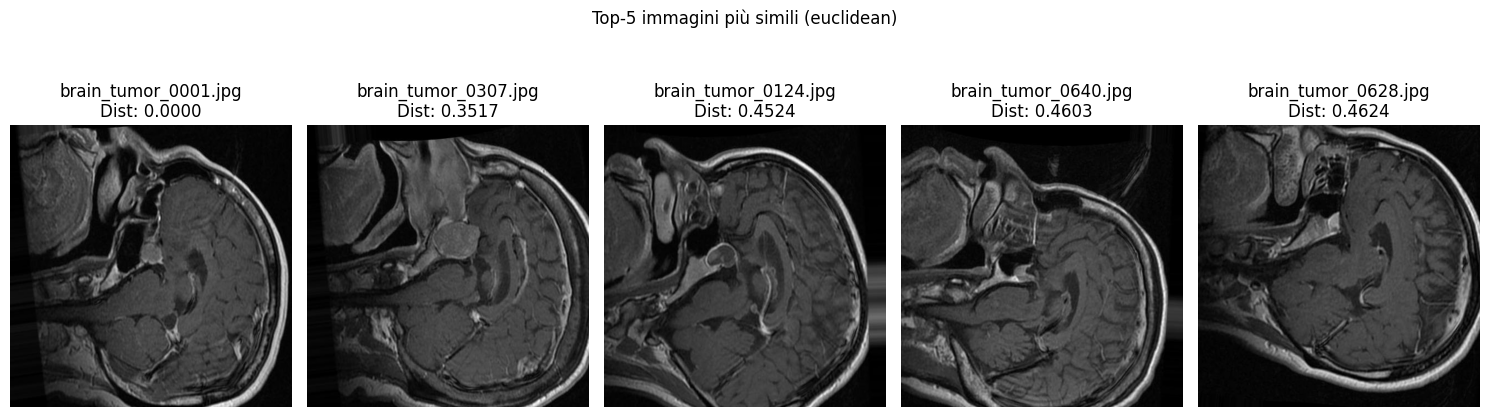

In [11]:
# === Parametri ===
query_image_path = "Part1/brain_tumor/brain_tumor_0001.jpg"  # Sostituisci con il percorso corretto
k = 5
features_npz = "resnet_features_part1.npz"
base_folder = "Part1"

# === Chiamata con distanza euclidea ===
# find_top_k_similar(query_image_path, k, features_npz, model, base_folder, metric="euclidean")

# === Chiamata con similarità coseno ===
find_top_k_similar(query_image_path, k, features_npz, model, base_folder, metric="euclidean")


Task 4:

In [13]:

def compute_metric(query_feat, target_feats, metric="euclidean"):
    """
    Calcola la distanza o similarità tra query_feat e un set di target_feats.
    """
    query_feat = query_feat.reshape(1, -1)
    if metric == "euclidean":
        return np.linalg.norm(target_feats - query_feat, axis=1)
    elif metric == "cosine":
        return cosine_similarity(query_feat, target_feats)[0]
    else:
        raise ValueError("Metric must be 'euclidean' or 'cosine'")

def predict_top_k_labels_distance_mean(query_img_path, k, model, metric="euclidean"):
    """
    Strategia 1: etichetta più vicina in media nel feature space.
    """
    data = np.load("resnet_features_all.npz")
    features = data['features']
    labels = data['labels']

    query_feat = extract_and_process_image(query_img_path, model)

    unique_labels = np.unique(labels)
    avg_scores = []

    for label in unique_labels:
        class_feats = features[labels == label]
        scores = compute_metric(query_feat, class_feats, metric)
        avg_scores.append(scores.mean())

    # Ordinamento (euclidea: valori più piccoli = migliori; cosine: valori più grandi = migliori)
    if metric == "euclidean":
        sorted_indices = np.argsort(avg_scores)
    else:  # cosine
        sorted_indices = np.argsort(avg_scores)[::-1]

    print(f"--- Top-{k} etichette - Distanza media ({metric}) ---")
    for i in range(min(k, len(unique_labels))):
        idx = sorted_indices[i]
        print(f"{unique_labels[idx]} \t Score medio: {avg_scores[idx]:.4f}")

def predict_top_k_labels_prototype(query_img_path, k, model, metric="euclidean"):
    """
    Strategia 2: distanza/similarità rispetto al prototipo (media) della classe.
    """
    data = np.load("resnet_features_all.npz")
    features = data['features']
    labels = data['labels']

    query_feat = extract_and_process_image(query_img_path, model)

    unique_labels = np.unique(labels)
    prototypes = []
    for label in unique_labels:
        class_feats = features[labels == label]
        prototypes.append(class_feats.mean(axis=0))
    prototypes = np.vstack(prototypes)

    scores = compute_metric(query_feat, prototypes, metric)

    if metric == "euclidean":
        sorted_indices = np.argsort(scores)
    else:
        sorted_indices = np.argsort(scores)[::-1]

    print(f"--- Top-{k} etichette - Prototipo classe ({metric}) ---")
    for i in range(min(k, len(unique_labels))):
        idx = sorted_indices[i]
        print(f"{unique_labels[idx]} \t Score: {scores[idx]:.4f}")

def task4_predict_labels(query_img_path, k, model, metric="euclidean"):
    assert k <= 2, "k deve essere <= 2"
    print(f"Predizione top-{k} per immagine '{query_img_path}' usando metrica '{metric}'")
    predict_top_k_labels_distance_mean(query_img_path, k, model, metric)
    print()
    predict_top_k_labels_prototype(query_img_path, k, model, metric)


Esecuzione

In [14]:
query_img = "Part2/brain_glioma/brain_glioma_1112.jpg"

task4_predict_labels(query_img, k=2, model=model, metric="euclidean")
print()
task4_predict_labels(query_img, k=2, model=model, metric="cosine")


Predizione top-2 per immagine 'Part2/brain_glioma/brain_glioma_1112.jpg' usando metrica 'euclidean'
--- Top-2 etichette - Distanza media (euclidean) ---
brain_glioma 	 Score medio: 0.6539
brain_menin 	 Score medio: 0.7890

--- Top-2 etichette - Prototipo classe (euclidean) ---
brain_glioma 	 Score: 0.3942
brain_menin 	 Score: 0.5319

Predizione top-2 per immagine 'Part2/brain_glioma/brain_glioma_1112.jpg' usando metrica 'cosine'
--- Top-2 etichette - Distanza media (cosine) ---
brain_glioma 	 Score medio: 0.9750
brain_menin 	 Score medio: 0.9644

--- Top-2 etichette - Prototipo classe (cosine) ---
brain_glioma 	 Score: 0.9911
brain_menin 	 Score: 0.9839


Task 5:

In [15]:
def plot_latent_space_2d(X_transformed, labels, technique, k):
    """Visualizza la proiezione 2D dello spazio latente."""
    if X_transformed.shape[1] < 2:
        print("[INFO] Meno di 2 componenti: impossibile visualizzare in 2D.")
        return

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette="Set2", s=80)
    plt.title(f"{technique.upper()} - Proiezione sulle prime 2 componenti latenti (k={k})")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_kmeans_clusters_2d(feature_matrix, labels, n_clusters):
    """Visualizza i cluster KMeans in 2D usando SVD per proiezione."""
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(feature_matrix)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels, palette='tab10', s=80, style=labels)
    plt.title(f"KMeans Clustering (k={n_clusters}) con proiezione SVD 2D")
    plt.xlabel("Componente Latente 1 (da SVD)")
    plt.ylabel("Componente Latente 2 (da SVD)")
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()


In [16]:

def task5_latent_semantics_resnet(feature_model_path, technique, k):
    """
    Estrae i top-k concetti latenti da uno spazio di feature ResNet usando SVD, LDA o KMeans.
    Salva i risultati su file e visualizza lo spazio latente.

    Parametri:
    ------------
    - feature_model_path: percorso file .npz (es. "resnet_layer3.npz")
    - technique: "svd", "lda", "kmeans"
    - k: numero componenti/cluster da estrarre
    """

    technique = technique.lower()

    if technique == "svd":
        model = TruncatedSVD(n_components=k, random_state=42)
        X_transformed = model.fit_transform(feat_matrix_part1)
        components = model.components_
        method = "svd"

    elif technique == "lda":
        unique_labels = np.unique(lbls_part1)
        max_k = len(unique_labels) - 1
        if k > max_k:
            print(f"[ATTENZIONE] LDA supporta al massimo {max_k} componenti con {len(unique_labels)} classi.")
            k = max_k
        model = LDA(n_components=k)
        X_transformed = model.fit_transform(feat_matrix_part1, lbls_part1)
        components = model.scalings_.T[:k]
        method = "lda"

    elif technique == "kmeans":
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(feat_matrix_part1)
        components = model.cluster_centers_
        X_transformed = model.transform(feat_matrix_part1)
        method = "kmeans"
    else:
        print("[ERRORE] Tecnica non supportata. Usa: 'svd', 'lda', 'kmeans'")
        return

    # === Visualizzazione ===
    if technique in ["svd", "lda"]:
        plot_latent_space_2d(X_transformed, lbls_part1, technique, k)
    elif technique == "kmeans":
        plot_kmeans_clusters_2d(feat_matrix_part1, lbls_part1, k)

    # === Output file ===
    base_name = os.path.splitext(os.path.basename(feature_model_path))[0]
    out_file = f"latent_semantics_{method}_{base_name}_k{k}.txt"

    with open(out_file, "w") as f:
        for i in range(k):
            f.write(f"\n--- Latent Semantic {i+1} ---\n")
            if technique in ["svd", "lda"]:
                weights = feat_matrix_part1 @ components[i].T
            else:
                weights = -X_transformed[:, i]  # distanza inversa

            sorted_idx = np.argsort(-np.abs(weights))
            for idx in sorted_idx:
                f.write(f"{flname_part1[idx]} | Peso: {weights[idx]:.4f} | Classe: {lbls_part1[idx]}\n")

    print(f"[SALVATO] Latent semantics salvati in: {out_file}")


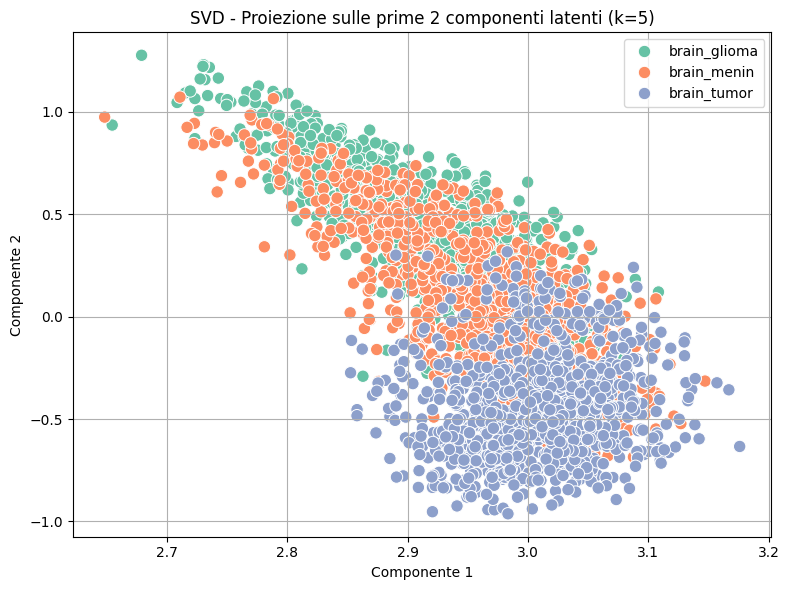

[SALVATO] Latent semantics salvati in: latent_semantics_svd_resnet_features_all_k5.txt


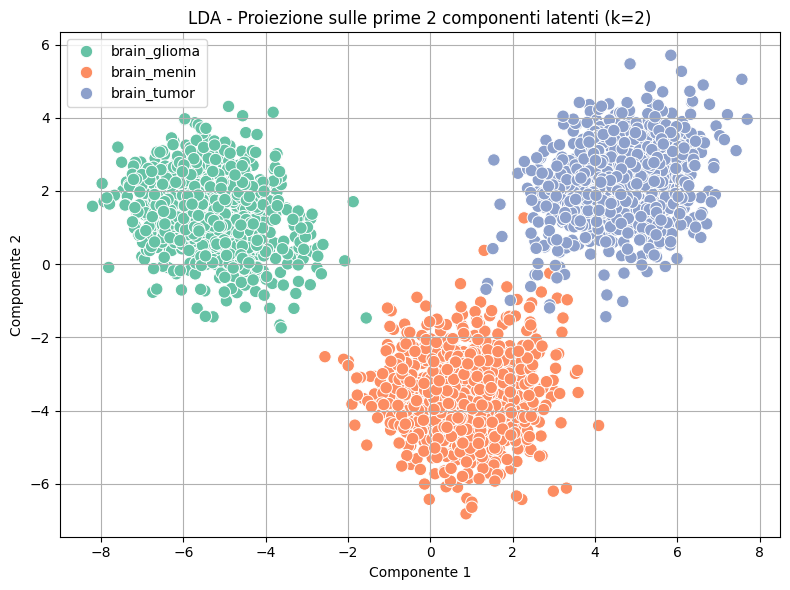

[SALVATO] Latent semantics salvati in: latent_semantics_lda_resnet_features_all_k2.txt


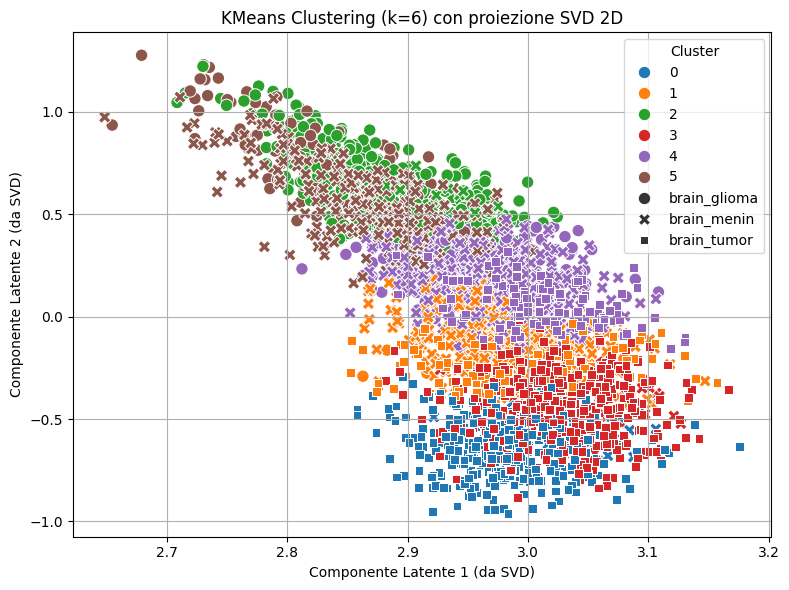

[SALVATO] Latent semantics salvati in: latent_semantics_kmeans_resnet_features_all_k6.txt


In [17]:
# Supponendo tu abbia salvato il file .npz come "resnet_layer3.npz"
task5_latent_semantics_resnet("resnet_features_all.npz", technique="svd", k=5)
task5_latent_semantics_resnet("resnet_features_all.npz", technique="lda", k=2)
task5_latent_semantics_resnet("resnet_features_all.npz", technique="kmeans", k=6)


Task 6:

In [22]:

def estimate_intrinsic_dimensionality(feature_matrix, threshold, plot=True):
    max_components = min(feature_matrix.shape)
    pca = PCA(n_components=max_components)
    pca.fit(feature_matrix)

    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)
    intrinsic_dim = np.argmax(cumulative >= threshold) + 1

    #print(f"[INFO] Spiegazione varianza per ogni componente PCA:\n{explained}")
    #print(f"[INFO] Varianza cumulativa:\n{cumulative}")
    #print(f"[INFO] Soglia impostata: {threshold}")
    #print(f"[INFO] Dimensione intrinseca stimata: {intrinsic_dim}")

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(cumulative, marker='o', label="Varianza cumulativa")
        plt.axhline(y=threshold, color='r', linestyle='--', label=f"Soglia {threshold*100:.0f}%")
        plt.axvline(x=intrinsic_dim, color='g', linestyle='--', label=f"k suggerito: {intrinsic_dim}")
        plt.xlabel("Numero componenti")
        plt.ylabel("Varianza cumulativa")
        plt.title("Scelta ottimale di k (PCA/SVD)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    print(f"[INFO] k ottimale suggerito (soglia {threshold*100:.0f}%): {intrinsic_dim}")
    return intrinsic_dim, cumulative

def suggest_k(feature_matrix, threshold_list=[0.90, 0.95, 0.99]):
    print(f"[INFO] Feature matrix shape: {feature_matrix.shape}")
    k_values = {}
    for t in threshold_list:
        k, _ = estimate_intrinsic_dimensionality(feature_matrix, threshold=t, plot=False)
        k_values[t] = k
        print(f"Soglia {int(t*100)}% : k = {k}")
    return k_values


In [23]:
def estimate_dimensionality_per_label(feature_matrix, labels, threshold):
    label_dim_map = {}

    unique_labels = np.unique(labels)
    print(f"[INFO] Etichette uniche trovate: {len(unique_labels)}")

    for label in unique_labels:
        indices = np.where(labels == label)[0]
        label_features = feature_matrix[indices]

        if len(indices) < 2:
            print(f"[AVVISO] Label '{label}' ha meno di 2 campioni — ignorata.")
            continue

        k, _ = estimate_intrinsic_dimensionality(label_features, threshold=threshold, plot=False)
        label_dim_map[label] = k
        print(f" Label '{label}' : k = {k}")

    return label_dim_map


<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
/var/folders/6q/jmt5rhf501363h2f7_4cnrjh0000gn/T/ipykernel_6120/1321706206.py:2: SyntaxWarning: invalid escape sequence '\S'
  print("\Stima automatica di k in base alla varianza spiegata:\n")


\Stima automatica di k in base alla varianza spiegata:

[INFO] Feature matrix shape: (3006, 1024)
[INFO] k ottimale suggerito (soglia 90%): 26
Soglia 90% : k = 26
[INFO] k ottimale suggerito (soglia 95%): 54
Soglia 95% : k = 54
[INFO] k ottimale suggerito (soglia 99%): 269
Soglia 99% : k = 269


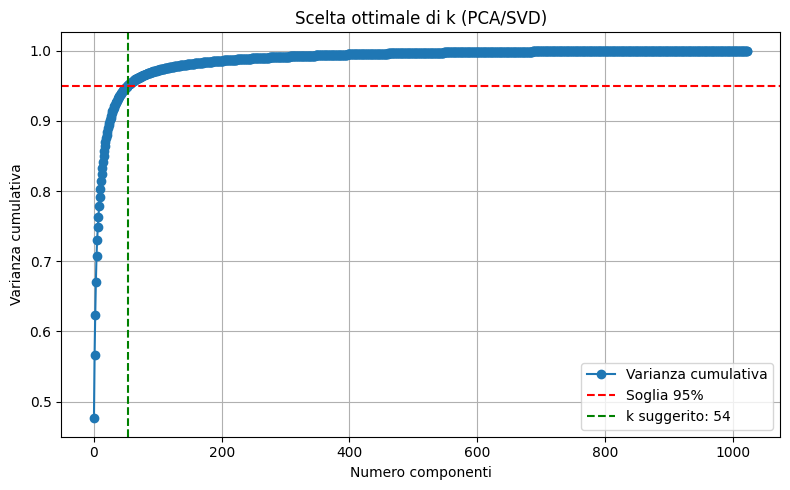

[INFO] k ottimale suggerito (soglia 95%): 54

 Task 6b – Dimensionalità per etichetta:

[INFO] Etichette uniche trovate: 3
[INFO] k ottimale suggerito (soglia 95%): 64
 Label 'brain_glioma' : k = 64
[INFO] k ottimale suggerito (soglia 95%): 62
 Label 'brain_menin' : k = 62
[INFO] k ottimale suggerito (soglia 95%): 75
 Label 'brain_tumor' : k = 75


In [24]:
# Calcola k per varie soglie
print("\Stima automatica di k in base alla varianza spiegata:\n")
k_suggeriti = suggest_k(feat_matrix_part1)
# Plot dettagliato per la soglia 95%
estimate_intrinsic_dimensionality(feat_matrix_part1, threshold=0.95, plot=True)


print("\n Task 6b – Dimensionalità per etichetta:\n")
label_dimensionalities = estimate_dimensionality_per_label(feat_matrix_part1, lbls_part1, threshold=0.95)

Task 7:

In [68]:
def compute_latent_semantics_per_class(X, y, k=10):
    class_models = {}
    class_means = {}

    labels = np.unique(y)
    for label in labels:
        X_class = X[y == label]  # Prende solo le istanze della classe corrente
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_class)  # Normalizza i dati della classe

        svd = TruncatedSVD(n_components=k)
        latent = svd.fit_transform(X_scaled)  # Riduzione dimensionale con SVD

        # Salva modello SVD e scaler per la classe
        class_models[label] = {
            'svd': svd,
            'scaler': scaler,
            'latent_vectors': latent
        }
        # Calcola la media dei vettori latenti della classe
        class_means[label] = np.mean(latent, axis=0)
    return class_models, class_means

def predict_label(X_test, class_models, class_means):
    y_pred = []
    for x in X_test:
        best_label = None
        min_dist = float('inf')
        for label, model in class_models.items():
            x_scaled = model['scaler'].transform(x.reshape(1, -1))  # Normalizza x
            x_latent = model['svd'].transform(x_scaled)  # Trasforma in spazio latente
            dist = np.linalg.norm(x_latent - class_means[label])  # Distanza dal centroide
            if dist < min_dist:
                min_dist = dist
                best_label = label
        y_pred.append(best_label)
    return y_pred


def evaluate(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    labels = np.unique(y_true)
    print("Per-class metrics:")
    for i, label in enumerate(labels):
        print(
            f"Class {label}: P={precision[i]:.2f}, R={recall[i]:.2f}, F1={f1[i]:.2f}")
    print(f"\nOverall Accuracy: {accuracy:.2f}\n")

    print(classification_report(y_true, y_pred))


def evaluate_predictions(true_labels, predicted_labels):
    print("[VALUTAZIONE] Report di classificazione:")
    print(classification_report(true_labels, predicted_labels))

In [69]:
# Addestramento sui dati di Part1
class_models, class_means = compute_latent_semantics_per_class(
    feat_matrix_part1, lbls_part1, k=10)

# Predizione su Part2
predicted_labels = predict_label(feat_matrix_part2, class_models, class_means)

# Valutazione
evaluate(lbls_part2, predicted_labels)

Per-class metrics:
Class brain_glioma: P=0.82, R=0.68, F1=0.74
Class brain_menin: P=0.56, R=0.57, F1=0.56
Class brain_tumor: P=0.73, R=0.83, F1=0.78

Overall Accuracy: 0.69

              precision    recall  f1-score   support

brain_glioma       0.82      0.68      0.74      1002
 brain_menin       0.56      0.57      0.56      1002
 brain_tumor       0.73      0.83      0.78      1002

    accuracy                           0.69      3006
   macro avg       0.70      0.69      0.69      3006
weighted avg       0.70      0.69      0.69      3006



task 8

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

def cluster_with_dbscan_per_class(X, y, filenames, eps, min_samples):
    label_clusters = {}

    for label in np.unique(y):
        X_class = X[y == label]
        fn_class = filenames[y == label]

        # Standardizzazione
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_class)

        # Clustering DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(X_scaled)
        labels_db = db.labels_

        print(f"[INFO] Classe {label}: trovati {len(np.unique(labels_db)) - (1 if -1 in labels_db else 0)} cluster")

        # Salva risultati
        label_clusters[label] = {
            'features': X_scaled,
            'cluster_labels': labels_db,
            'filenames': fn_class
        }

        # Visualizzazione 2D
        visualize_mds(X_scaled, labels_db, label)

        # Visualizzazione thumbnails
        show_cluster_thumbnails(fn_class, labels_db, label)

    return label_clusters


def visualize_mds(X, cluster_labels, label, max_points=500):
    # Riduci campioni per grafico se troppi
    if len(X) > max_points:
        idx = np.random.choice(len(X), max_points, replace=False)
        X = X[idx]
        cluster_labels = cluster_labels[idx]

    mds = MDS(n_components=2, random_state=42, dissimilarity='euclidean')
    X_2d = mds.fit_transform(X)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, cmap='tab10', s=50, alpha=0.7)
    plt.title(f"MDS 2D - Classe {label}")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.colorbar(scatter, label="Cluster")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def show_cluster_thumbnails(filenames, cluster_labels, label, thumb_size=(64, 64), images_per_row=10):
    clusters = np.unique(cluster_labels)
    for clust in clusters:
        if clust == -1:
            continue  # Salta outlier
        indices = np.where(cluster_labels == clust)[0]
        n_images = len(indices)
        if n_images == 0:
            continue
        print(f"[CLUSTER] Classe {label} - Cluster {clust} - {n_images} immagini")

        n_rows = int(np.ceil(n_images / images_per_row))
        fig, axs = plt.subplots(n_rows, images_per_row, figsize=(images_per_row, n_rows))
        axs = axs.ravel()

        for i, ax in enumerate(axs):
            if i < n_images:
                try:
                    img = Image.open(filenames[indices[i]]).resize(thumb_size)
                    ax.imshow(img)
                    ax.axis('off')
                except:
                    ax.axis('off')
            else:
                ax.axis('off')

        plt.suptitle(f"Thumbnails - Classe {label} - Cluster {clust}", fontsize=14)
        plt.tight_layout()
        plt.show()


[INFO] Classe brain_glioma: trovati 0 cluster


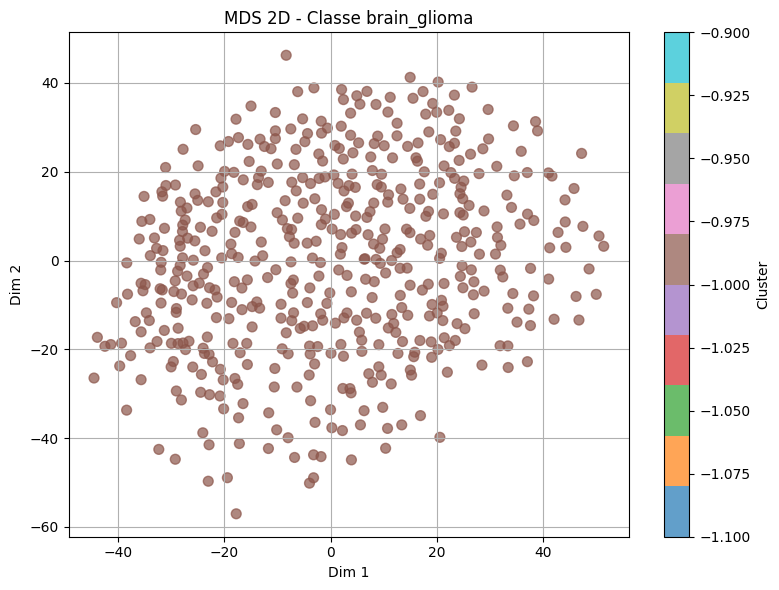

[INFO] Classe brain_menin: trovati 0 cluster


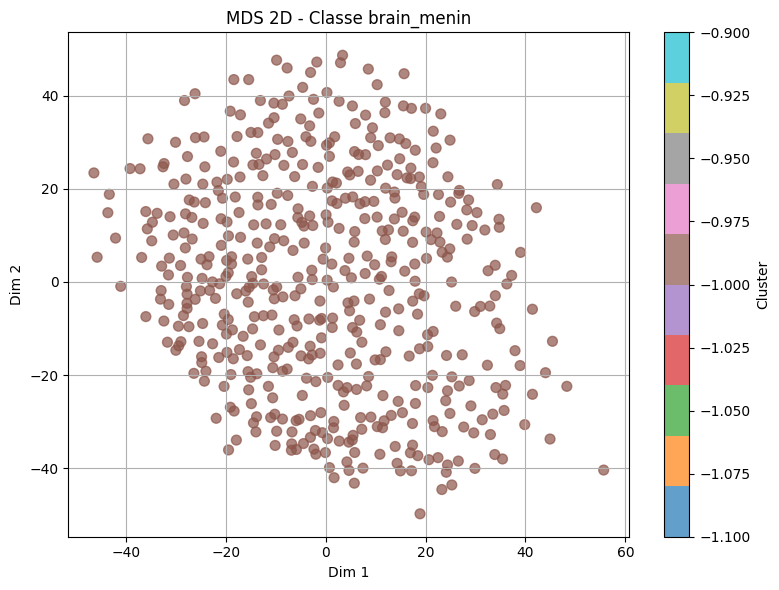

[INFO] Classe brain_tumor: trovati 0 cluster


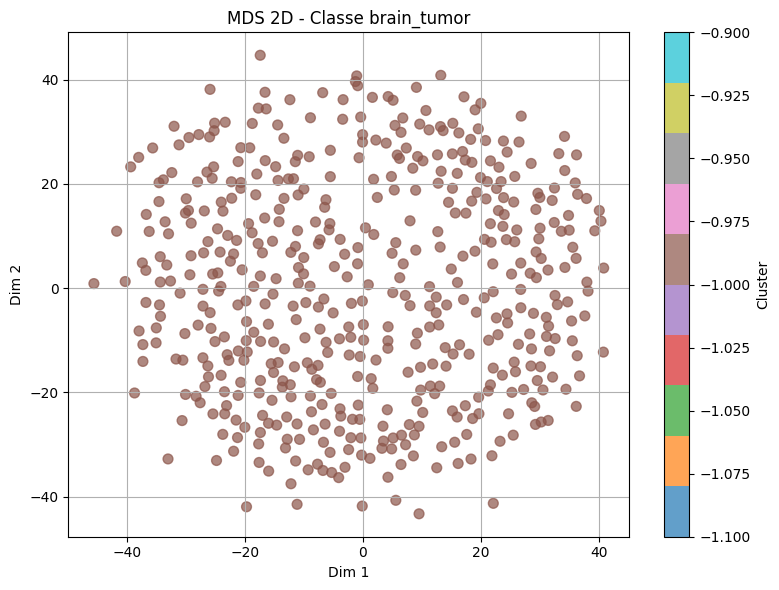

In [75]:
# Carica il modello delle feature
data = np.load("resnet_features_part1.npz", allow_pickle=True)
X = data['features']
y = data['labels']
filenames = data['filenames']

# Esegui clustering per ciascuna classe
label_clusters = cluster_with_dbscan_per_class(X, y, filenames, eps=10.0, min_samples=5)
